In [ ]:
%pip install numpy torch torchvision torchaudio scikit-image matplotlib

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from skimage import io
from skimage.transform import resize
import torch.utils.data as data
from dotenv import load_dotenv
from sklearn.metrics import precision_score, recall_score, f1_score
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
# Load environment variables from .env file
load_dotenv()
data_directory = os.getenv("DATASET1")

In [23]:
# verify existance of directory
if os.path.exists(data_directory):
    print("Directory exists")
    print(os.listdir(data_directory))
else:
    print("Directory does not exist:", data_directory)

Directory exists
['CHNCXR_0492_1.png', 'CHNCXR_0187_0.png', 'CHNCXR_0342_1.png', 'CHNCXR_0286_0.png', 'CHNCXR_0022_0.png', 'CHNCXR_0067_0.png', 'CHNCXR_0572_1.png', 'CHNCXR_0537_1.png', 'CHNCXR_0323_0.png', 'CHNCXR_0636_1.png', 'CHNCXR_0147_0.png', 'CHNCXR_0102_0.png', 'CHNCXR_0417_1.png', 'CHNCXR_0452_1.png', 'CHNCXR_0246_0.png', 'CHNCXR_0203_0.png', 'CHNCXR_0382_1.png', 'CHNCXR_0083_0.png', 'CHNCXR_0596_1.png', 'CHNCXR_0262_0.png', 'CHNCXR_0227_0.png', 'CHNCXR_0433_1.png', 'CHNCXR_0476_1.png', 'CHNCXR_0163_0.png', 'CHNCXR_0126_0.png', 'CHNCXR_0366_1.png', 'CHNCXR_0657_1.png', 'CHNCXR_0612_1.png', 'CHNCXR_0307_0.png', 'CHNCXR_0556_1.png', 'CHNCXR_0513_1.png', 'CHNCXR_0006_0.png', 'CHNCXR_0043_0.png', 'CHNCXR_0218_0.png', 'CHNCXR_0399_1.png', 'CHNCXR_0119_0.png', 'CHNCXR_0364_1.png', 'CHNCXR_0449_1.png', 'CHNCXR_0004_0.png', 'CHNCXR_0041_0.png', 'CHNCXR_0554_1.png', 'CHNCXR_0511_1.png', 'CHNCXR_0305_0.png', 'CHNCXR_0655_1.png', 'CHNCXR_0610_1.png', 'CHNCXR_0594_1.png', 'CHNCXR_0081_0.p

In [24]:
all_files = os.listdir(data_directory)
all_files = [f for f in all_files if f.endswith('.png') and f[-5] in ['0', '1']] # filtering for images with 0 and 1
print("Valid images:" ,len(all_files))

Valid images: 662


In [25]:
device = None
if torch.backends.mps.is_available():
    device = torch.device('mps')  
elif torch.xpu.is_available():
    device = torch.device("xpu")
    print("Using Intel GPU")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
print("Device Category: ",device)

Device Category:  mps


In [26]:
data_transforms = transforms.Compose([transforms.ToTensor()])


# function to pre process image for model
def CNNloader(data_root, filename):

    filename_actual = data_root + '/' + filename
    data_old = io.imread(filename_actual)

    # Resize image to 224x224
    data_old = resize(data_old, (224, 224))
    data_old = np.array(data_old, dtype=np.float32)
    
    # Convert 2 channel data to 3 channel
    if len(data_old.shape) <= 2:
        data_new = np.zeros(data_old.shape + (3,))
        data_new[:,:,0] = data_new[:,:,1] = data_new[:,:,2] = np.array(data_old)
        data_old = np.array(data_new, dtype=np.float32)
    
    # Applying transform
    data_old = data_transforms(np.array(data_old))
    return data_old


In [27]:
# converts our image to a format the network can understand
class CNNDataLayer(data.Dataset):
    def __init__(self, data_root, filenames, loader):
        self.data_root = data_root
        self.filenames = filenames
        self.loader = loader

    # returning data and extracted label from filename
    def __getitem__(self, index):
        filename = self.filenames[index]
        target = [int(filename[-5])]
        target = torch.from_numpy(np.array(target))
        data = self.loader(self.data_root, filename)
        return data, target

    # dataset size
    def __len__(self):
        return len(self.filenames)

In [30]:
all_files = np.array(all_files)
print(all_files.shape)
np.random.shuffle(all_files)

# Split our data: 70% for training, 30% for testing
# Determine the split index for 70% of the data
split_index = int(0.70 * len(all_files))
train_files = all_files[:split_index]
test_files = all_files[split_index:]
print(train_files.shape, test_files.shape)


(662,)
(463,) (199,)


In [31]:
data_sets_train = CNNDataLayer(data_root=data_directory, filenames=train_files, loader=CNNloader)
data_sets_test = CNNDataLayer(data_root=data_directory, filenames=test_files, loader=CNNloader)

# Create data loaders
data_loaders_train = data.DataLoader(data_sets_train, batch_size=8, shuffle=True, num_workers=0)
data_loaders_test = data.DataLoader(data_sets_test, batch_size=8, shuffle=True, num_workers=0)

model_to_train = models.vgg16(weights='IMAGENET1K_V1')

# retaining pre trained logic
for param in model_to_train.features.parameters():
    param.require_grad = False

# adding layer for classification
num_features = model_to_train.classifier[6].in_features
features = list(model_to_train.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 1), nn.Sigmoid()])
model_to_train.classifier = nn.Sequential(*features)

model_to_train = model_to_train.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer_ft = optim.SGD(model_to_train.parameters(), lr=0.001, momentum=0.9)


In [33]:
number_of_epochs = 1  
# Get the current date and time
now = datetime.now()
Saved_path = "VGG16-output" + "/" + now.strftime("%Y-%m-%d_%H-%M-%S")


for epoch in range(number_of_epochs):
    print('Epoch is ' + str(epoch))
    train_loss = 0
    test_loss = 0
    total_misclassified_train = total_count_train = 0
    total_misclassified_test = total_count_test = 0
    
    # Training stage
    # ---------------------------------------------------------------------------------------


    model_to_train.train()
    for batch_idx, (data_now, target_now) in enumerate(data_loaders_train):

        data_now, target_now = data_now.to(device), target_now.to(device)
        

        target_output_model = model_to_train(data_now)
        target_now = target_now.type(torch.FloatTensor).to(device)
        
        # Calculating losses
        target_loss = criterion(target_output_model, target_now)
        
        # stats
        misclassified_temp = target_output_model[target_now == 1]
        total_misclassified_train += (misclassified_temp < 0.5).sum().item()
        misclassified_temp = target_output_model[target_now == 0]
        total_misclassified_train += (misclassified_temp >= 0.5).sum().item()
        total_count_train += data_now.shape[0]
        
        # Backpropagation
        optimizer_ft.zero_grad()
        target_loss.backward()
        optimizer_ft.step()
    
    
    # Testing stage
    # ---------------------------------------------------------------------------------------

    model_to_train.eval()
    all_predictions = []
    all_targets = []

    # Disabling training logic
    with torch.no_grad():
        for batch_idx, (data_now, target_now) in enumerate(data_loaders_test):

            data_now, target_now = data_now.to(device), target_now.to(device)
            target_output_model = model_to_train(data_now)
            
            predicted_labels = (target_output_model >= 0.5).float()
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_targets.extend(target_now.cpu().numpy())
            
            # Calculate how many predictions were wrong
            misclassified_temp = target_output_model[target_now == 1]
            total_misclassified_test += (misclassified_temp < 0.5).sum().item()
            misclassified_temp = target_output_model[target_now == 0]
            total_misclassified_test += (misclassified_temp >= 0.5).sum().item()
            total_count_test += data_now.shape[0]
    
    # Converting to numpy arrays 
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets).flatten()
    
    # Calculate evaluation metrics
    accuracy = np.mean(all_predictions == all_targets)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    
    # Print evaluation metrics
    print(f'Epoch {epoch} - Test Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Saving model weights 
    
    os.makedirs(Saved_path, exist_ok=True)
    epoch_model_name = f'epoch-{epoch}-trainerror-{total_misclassified_train/total_count_train:.4f}-testerror-{total_misclassified_test/total_count_test:.4f}.pth'
    torch.save(model_to_train.state_dict(), os.path.join(Saved_path, epoch_model_name))

Epoch is 0
Epoch 0 - Test Metrics:
Accuracy: 0.8392
Precision: 0.8916
Recall: 0.7629
F1 Score: 0.8222


In [34]:
#  running over testing files to print number of True positives, True negatives, False positives, False negatives
# Function to evaluate the model and generate predictions
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()  # Apply threshold for binary classification

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


In [35]:
test_loader = data_loaders_test  

# Get true labels and predictions
true_labels, predictions = evaluate_model(model_to_train, test_loader)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)


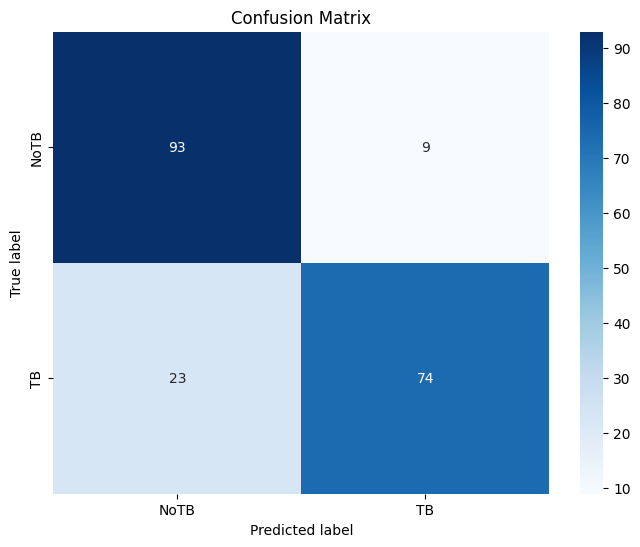

In [36]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['NoTB', 'TB']
plot_confusion_matrix(cm, class_names)